In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sqlalchemy import create_engine

In [2]:
df = pd.read_csv('C:\\Users\\jc\\Desktop\\python_projects\\telecom_customer_churn.csv')

# Create an in-memory SQLite database
engine = create_engine("sqlite:///:memory:")

# Push DataFrame to the in-memory database
df.to_sql("telecom_customer_churn", engine, index=False)

7043

In [3]:
df.shape

(7043, 38)

In [4]:
df.head

<bound method NDFrame.head of      Customer ID  Gender  Age Married  Number of Dependents          City  \
0     0002-ORFBO  Female   37     Yes                     0  Frazier Park   
1     0003-MKNFE    Male   46      No                     0      Glendale   
2     0004-TLHLJ    Male   50      No                     0    Costa Mesa   
3     0011-IGKFF    Male   78     Yes                     0      Martinez   
4     0013-EXCHZ  Female   75     Yes                     0     Camarillo   
...          ...     ...  ...     ...                   ...           ...   
7038  9987-LUTYD  Female   20      No                     0       La Mesa   
7039  9992-RRAMN    Male   40     Yes                     0     Riverbank   
7040  9992-UJOEL    Male   22      No                     0           Elk   
7041  9993-LHIEB    Male   21     Yes                     0  Solana Beach   
7042  9995-HOTOH    Male   36     Yes                     0   Sierra City   

      Zip Code   Latitude   Longitude  Number

In [5]:
df.columns.values

array(['Customer ID', 'Gender', 'Age', 'Married', 'Number of Dependents',
       'City', 'Zip Code', 'Latitude', 'Longitude', 'Number of Referrals',
       'Tenure in Months', 'Offer', 'Phone Service',
       'Avg Monthly Long Distance Charges', 'Multiple Lines',
       'Internet Service', 'Internet Type', 'Avg Monthly GB Download',
       'Online Security', 'Online Backup', 'Device Protection Plan',
       'Premium Tech Support', 'Streaming TV', 'Streaming Movies',
       'Streaming Music', 'Unlimited Data', 'Contract',
       'Paperless Billing', 'Payment Method', 'Monthly Charge',
       'Total Charges', 'Total Refunds', 'Total Extra Data Charges',
       'Total Long Distance Charges', 'Total Revenue', 'Customer Status',
       'Churn Category', 'Churn Reason'], dtype=object)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 38 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Customer ID                        7043 non-null   object 
 1   Gender                             7043 non-null   object 
 2   Age                                7043 non-null   int64  
 3   Married                            7043 non-null   object 
 4   Number of Dependents               7043 non-null   int64  
 5   City                               7043 non-null   object 
 6   Zip Code                           7043 non-null   int64  
 7   Latitude                           7043 non-null   float64
 8   Longitude                          7043 non-null   float64
 9   Number of Referrals                7043 non-null   int64  
 10  Tenure in Months                   7043 non-null   int64  
 11  Offer                              3166 non-null   objec

# Data Cleaning

# 1. Find the number of customers

In [7]:
query = """
SELECT  Count(Distinct"Customer ID") AS Total_customers
FROM telecom_customer_churn

"""
result = pd.read_sql(query, engine)
print(result)

   Total_customers
0             7043


# 2. Find duplicate rows

In [8]:
query = """
SELECT "Customer ID", Count(*) AS Total_Duplicates
FROM telecom_customer_churn
Group By "Customer ID" 
Having Count(*) > 1

"""
result = pd.read_sql(query, engine)
print(result)

Empty DataFrame
Columns: [Customer ID, Total_Duplicates]
Index: []


# Data Analyzation and Visualization

# What is gender's proportion churned?

In [9]:
query = """
SELECT
    
COUNT(Case When Gender = 'Male' THEN 1 END)  AS Total_male,
COUNT(CASE WHEN Gender = 'Female' THEN 1 END) AS Total_female
 
FROM telecom_customer_churn
where "Customer status" = 'Churned'
"""
result = pd.read_sql(query, engine)
print(result)

   Total_male  Total_female
0         930           939


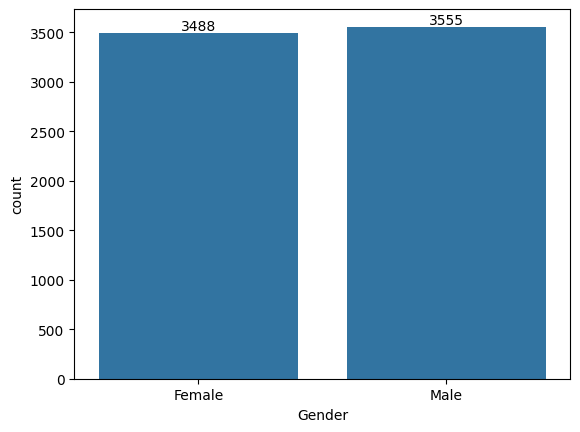

In [10]:
ax = sns.countplot(x = 'Gender', data = df)

for bars in ax.containers:
    ax.bar_label(bars)
plt.show()

# What is proportion of customers who have churned?

In [11]:
query = """
SELECT  
    ROUND((COUNT(CASE WHEN "Customer Status" = 'Churned' THEN 1 END) * 100.0) / COUNT(*),2) AS proportion_churned
From telecom_customer_churn;
"""
result = pd.read_sql(query, engine)
print(result)

   proportion_churned
0               26.54


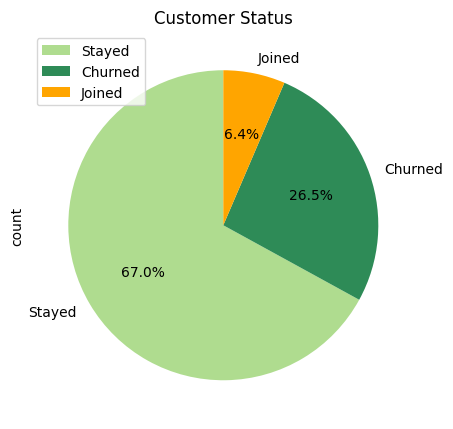

In [21]:
color = ['#AFDC8F', 'Seagreen', 'Orange']
df['Customer Status'].value_counts().plot(kind='pie',
                                        colors = color,
                                        figsize=(5,6),
                                        autopct='%1.1f%%',
                                        shadow = False,
                                        startangle=90)
plt.title("Customer Status")
plt.legend()

# What is average age of the customers that joined , stayed and churned?

In [22]:
query = """
SELECT  
    ROUND(AVG(CASE WHEN "Customer Status" = 'Joined' THEN Age END),2) AS Avg_Age_Joined,
       ROUND(AVG(CASE WHEN "Customer Status" = 'Stayed' THEN Age END),2) AS Avg_Age_Stayed,
          ROUND(AVG(CASE WHEN "Customer Status" = 'Churned' THEN Age END),2) AS Avg_Age_Churned
From telecom_customer_churn;
"""
result = pd.read_sql(query, engine)
print(result)

   Avg_Age_Joined  Avg_Age_Stayed  Avg_Age_Churned
0           42.87           45.58            49.74


# The marital status of customers has correlation with churned?

In [23]:
query = """
SELECT  
 Married,
  Count(Married) AS total,
    ROUND((Count(*) * 100.0 / (select count(*) from telecom_customer_churn where "Customer Status" = 'Churned' )), 2) AS Proportion_churned
      
From telecom_customer_churn
where "Customer Status" = 'Churned'
Group by Married
"""
result = pd.read_sql(query, engine)
print(result)

  Married  total  Proportion_churned
0      No   1200               64.21
1     Yes    669               35.79


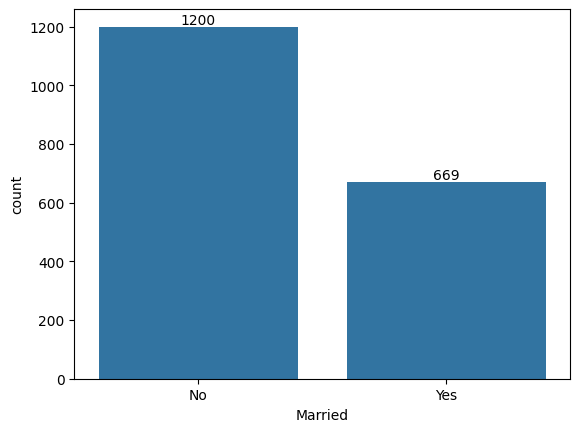

In [67]:

churned_df = df[df['Customer Status'] == 'Churned']

ax = sns.countplot(x='Married', data=churned_df, 
                   order=churned_df['Married'].value_counts().index)

for bars in ax.containers:
    ax.bar_label(bars)
plt.show()

# What is the better offer for each customer’s status?

In [30]:
query = """
SELECT  
"Customer Status",  
 Offer,
 Count(Offer) AS Total_Offer
From telecom_customer_churn
Group by "Customer Status", Offer
Order by "Customer Status", Offer DESC
"""
result = pd.read_sql(query, engine)
print(result)

   Customer Status    Offer  Total_Offer
0          Churned  Offer E          426
1          Churned  Offer D          161
2          Churned  Offer C           95
3          Churned  Offer B          101
4          Churned  Offer A           35
5          Churned     None            0
6           Joined  Offer E          175
7           Joined     None            0
8           Stayed  Offer E          204
9           Stayed  Offer D          441
10          Stayed  Offer C          320
11          Stayed  Offer B          723
12          Stayed  Offer A          485
13          Stayed     None            0


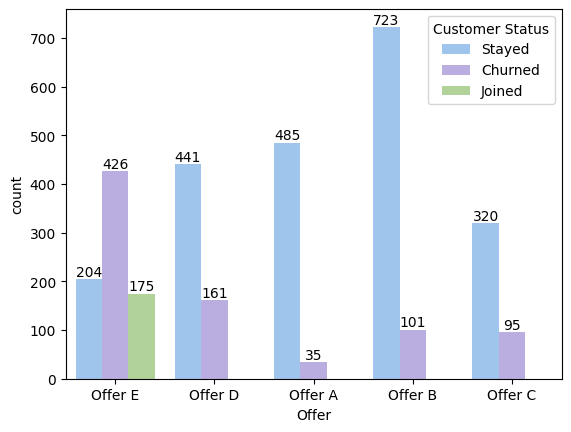

In [65]:
custom_palette = {'Churned': '#B6A6E9',  
    'Stayed': '#92C5F9',   
    'Joined': '#AFDC8F'    
}
ax = sns.countplot(x = 'Offer', hue = 'Customer Status', data = df, palette = custom_palette)

for bars in ax.containers:
    ax.bar_label(bars)
plt.show()

# What is the average of tenure in months for each customer’s status?

In [42]:
query = """
SELECT  
"Customer Status",
 Round(AVG("Tenure in Months"),2) AS Avg_Tenure
From telecom_customer_churn
Group by "Customer Status"
Order by Avg_Tenure DESC
"""
result = pd.read_sql(query, engine)
print(result)

  Customer Status  Avg_Tenure
0          Stayed       41.04
1         Churned       17.98
2          Joined        1.72


# Total payment method  for each customer's status 

In [41]:
query = """
SELECT  
"Customer Status",
 "Payment Method",
 Count("Payment Method") AS total_Payment_Method
From telecom_customer_churn
Group by "Customer Status", "Payment Method"

"""
result = pd.read_sql(query, engine)
print(result)

  Customer Status   Payment Method  total_Payment_Method
0         Churned  Bank Withdrawal                  1329
1         Churned      Credit Card                   398
2         Churned     Mailed Check                   142
3          Joined  Bank Withdrawal                   181
4          Joined      Credit Card                   231
5          Joined     Mailed Check                    42
6          Stayed  Bank Withdrawal                  2399
7          Stayed      Credit Card                  2120
8          Stayed     Mailed Check                   201


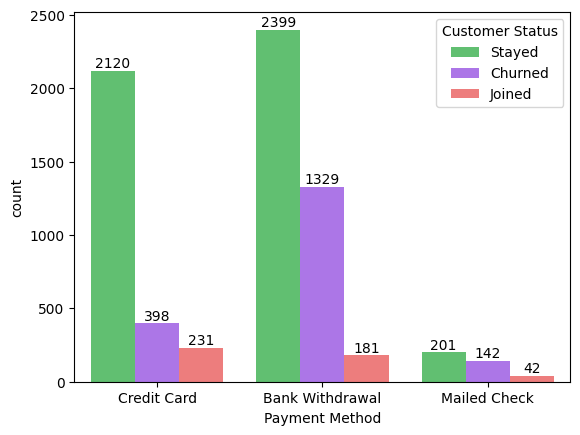

In [62]:
custom_palette = {'Churned': '#AB63FA',  
    'Stayed': '#51cf66',   
    'Joined': '#ff6b6b'   
}
ax = sns.countplot(x='Payment Method', hue = 'Customer Status', data=df, palette = custom_palette)

for bars in ax.containers:
    ax.bar_label(bars)
plt.show()

#  Total of internet service for each customer’s status

In [57]:
query = """
SELECT  
"Customer Status",
 "Internet Service",
 Count("Internet Service") AS total_Internet_Service
From telecom_customer_churn
Where "Internet Service" IS NOT NULL
Group by "Customer Status", "Internet Service"
Order by  "Customer Status", "Internet Service" DESC

"""
result = pd.read_sql(query, engine)
print(result)

  Customer Status Internet Service  total_Internet_Service
0         Churned              Yes                    1756
1         Churned               No                     113
2          Joined              Yes                     272
3          Joined               No                     182
4          Stayed              Yes                    3489
5          Stayed               No                    1231


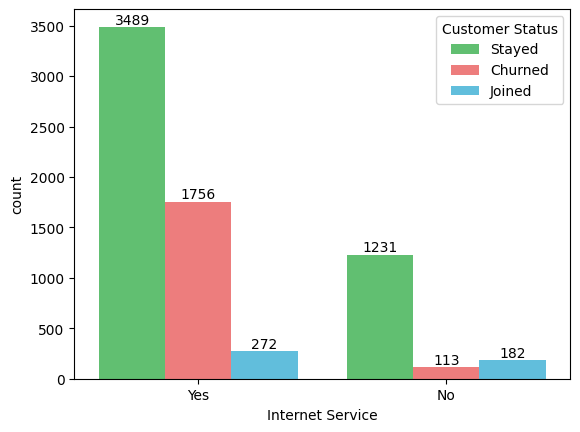

In [74]:
custom_palette = {
    'Churned': '#ff6b6b', 
    'Stayed': '#51cf66',  
    'Joined': '#4cc9f0'    
}
ax = sns.countplot(x='Internet Service', hue = 'Customer Status', data=df, palette=custom_palette)

for bars in ax.containers:
    ax.bar_label(bars)
plt.show()

#  Total of multiple lines for each customer’s status

In [68]:
query = """
SELECT  
"Customer Status",
 "Multiple Lines",
 Count("Multiple Lines") AS total_Multiple_Lines
From telecom_customer_churn
Where "Multiple Lines" IS NOT NULL
Group by "Customer Status", "Multiple Lines"
Order by  "Customer Status", "Multiple Lines" DESC

"""
result = pd.read_sql(query, engine)
print(result)

  Customer Status Multiple Lines  total_Multiple_Lines
0         Churned            Yes                   850
1         Churned             No                   849
2          Joined            Yes                    45
3          Joined             No                   371
4          Stayed            Yes                  2076
5          Stayed             No                  2170


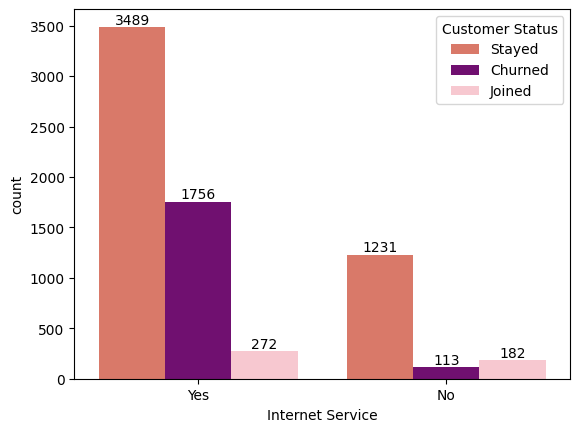

In [70]:
custom_palette = { 'Pink', 'Purple', '#EC6B56'}
ax = sns.countplot(x='Internet Service', hue = 'Customer Status', data=df, palette=custom_palette)

for bars in ax.containers:
    ax.bar_label(bars)
plt.show()

# Main internet type for each customer’s status

In [71]:
query = """
SELECT  
"Customer Status",
 "Internet Type",
 Count("Internet Type") AS total_Internet_Type
From telecom_customer_churn
Where "Internet Type" IS NOT NULL
Group by "Customer Status", "Internet Type"
Order by  "Customer Status", "Internet Type" DESC

"""
result = pd.read_sql(query, engine)
print(result)

  Customer Status Internet Type  total_Internet_Type
0         Churned   Fiber Optic                 1236
1         Churned           DSL                  307
2         Churned         Cable                  213
3          Joined   Fiber Optic                  101
4          Joined           DSL                  115
5          Joined         Cable                   56
6          Stayed   Fiber Optic                 1698
7          Stayed           DSL                 1230
8          Stayed         Cable                  561


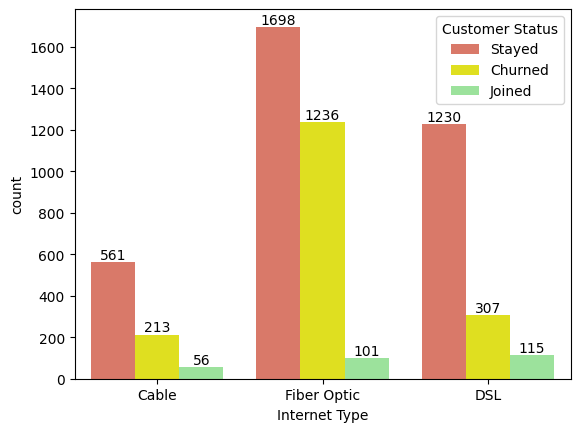

In [73]:
custom_palette = { 'yellow', '#EC6B56', 'lightgreen'}
ax = sns.countplot(x='Internet Type', hue = 'Customer Status', data=df, palette=custom_palette)

for bars in ax.containers:
    ax.bar_label(bars)
plt.show()

# Average monthly of gb download for each customer’s status

In [76]:
query = """
SELECT  
"Customer Status",
 Round(AVG("Avg Monthly GB Download"),2) AS Avg_Download
From telecom_customer_churn
Where "Avg Monthly GB Download" IS NOT NULL
Group by "Customer Status"
Order by "Avg Monthly GB Download" DESC

"""
result = pd.read_sql(query, engine)
print(result)

  Customer Status  Avg_Download
0         Churned         23.60
1          Joined         25.50
2          Stayed         27.55


# Streaming movies plan for each customer's status

In [78]:
query = """
SELECT  
"Customer Status",
"Streaming Movies",
 Count("Streaming Movies") AS total_movies
 
From telecom_customer_churn
Where "Streaming Movies" IS NOT NULL

Group by "Customer Status", "Streaming Movies"


"""
result = pd.read_sql(query, engine)
print(result)

  Customer Status Streaming Movies  total_movies
0         Churned               No           938
1         Churned              Yes           818
2          Joined               No           223
3          Joined              Yes            49
4          Stayed               No          1624
5          Stayed              Yes          1865


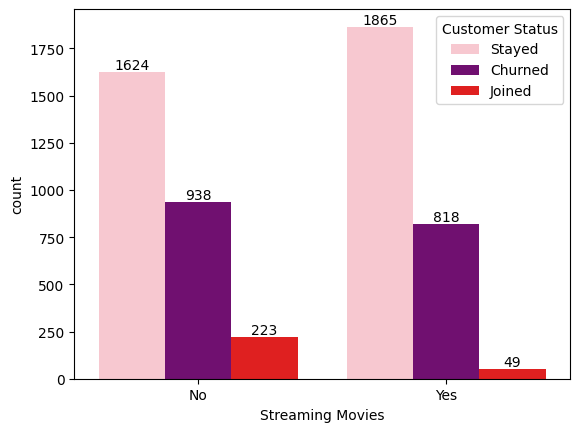

In [85]:
custom_palette = { 'purple', 'red', 'pink'}
ax = sns.countplot(x='Streaming Movies', hue = 'Customer Status', data=df, palette=custom_palette)

for bars in ax.containers:
    ax.bar_label(bars)
plt.show()

# Streaming TV plan for each customer's status

In [ ]:
query = """
SELECT  
"Customer Status",
"Streaming TV",
 Count("Streaming TV") AS total
 
From telecom_customer_churn
Where "Streaming TV" IS NOT NULL

Group by "Customer Status", "Streaming TV"


"""
result = pd.read_sql(query, engine)
print(result)

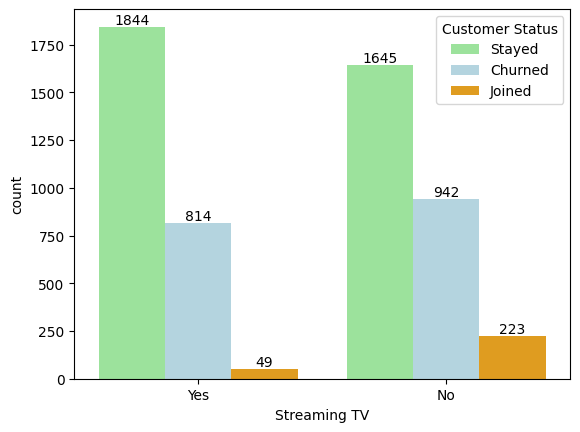

In [87]:
custom_palette = { 'orange', 'lightblue', 'lightgreen'}
ax = sns.countplot(x='Streaming TV', hue = 'Customer Status', data=df, palette=custom_palette)

for bars in ax.containers:
    ax.bar_label(bars)
plt.show()

# Streaming music plan for each customer's status

In [88]:
query = """
SELECT  
"Customer Status",
"Streaming Music",
 Count("Streaming Music") AS total
 
From telecom_customer_churn
Where "Streaming Music" IS NOT NULL

Group by "Customer Status", "Streaming Music"


"""
result = pd.read_sql(query, engine)
print(result)

  Customer Status Streaming Music  total
0         Churned              No   1028
1         Churned             Yes    728
2          Joined              No    220
3          Joined             Yes     52
4          Stayed              No   1781
5          Stayed             Yes   1708


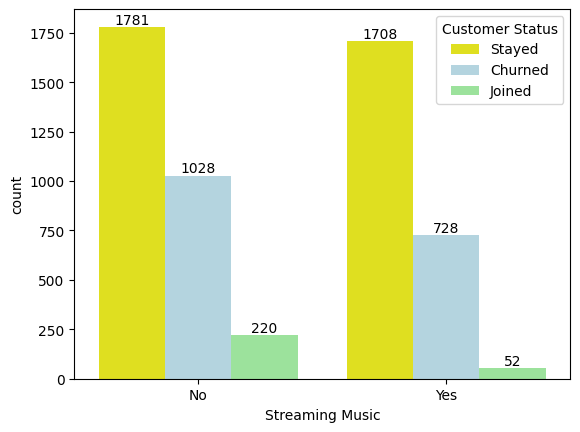

In [91]:
custom_palette = {'lightblue','yellow', 'lightgreen'}
ax = sns.countplot(x='Streaming Music', hue = 'Customer Status', data=df, palette=custom_palette)

for bars in ax.containers:
    ax.bar_label(bars)
plt.show()

# More used type of contract by each customer’s status

In [92]:
query = """
SELECT  
"Customer Status",
Contract,
 Count(Contract) AS total
 
From telecom_customer_churn
Where Contract IS NOT NULL

Group by "Customer Status", Contract


"""
result = pd.read_sql(query, engine)
print(result)

  Customer Status        Contract  total
0         Churned  Month-to-Month   1655
1         Churned        One Year    166
2         Churned        Two Year     48
3          Joined  Month-to-Month    408
4          Joined        One Year     24
5          Joined        Two Year     22
6          Stayed  Month-to-Month   1547
7          Stayed        One Year   1360
8          Stayed        Two Year   1813


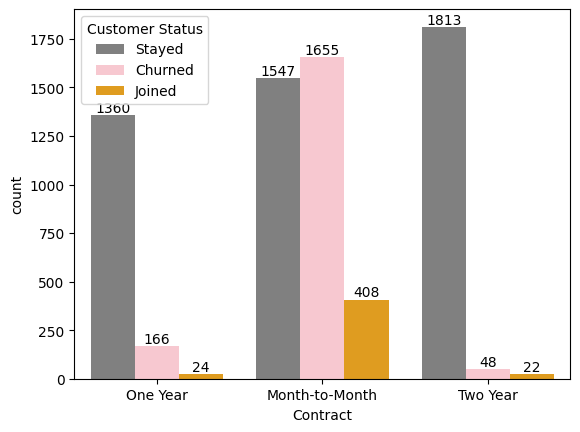

In [97]:
custom_palette = { 'orange', 'gray', 'pink'}
ax = sns.countplot(x='Contract', hue = 'Customer Status', data=df, palette=custom_palette)

for bars in ax.containers:
    ax.bar_label(bars)
plt.show()

# Average of monthly charge for each customer’s status

In [98]:
query = """
SELECT  
"Customer Status",
 Round(Avg("Monthly Charge"),2) AS Avg_Monthly_Charge
 
From telecom_customer_churn
Where "Monthly Charge" IS NOT NULL

Group by "Customer Status"


"""
result = pd.read_sql(query, engine)
print(result)

  Customer Status  Avg_Monthly_Charge
0         Churned               73.35
1          Joined               42.78
2          Stayed               61.74


# Average of total charge for each customer’s status

In [99]:
query = """
SELECT  
"Customer Status",
 Round(Avg("Total Charges"),2) AS Avg_Total_Charges
 
From telecom_customer_churn
Where "Total Charges" IS NOT NULL

Group by "Customer Status"


"""
result = pd.read_sql(query, engine)
print(result)

  Customer Status  Avg_Total_Charges
0         Churned            1531.80
1          Joined              79.29
2          Stayed            2788.52


# Average of total refunds for each customer’s status

In [101]:
query = """
SELECT  
"Customer Status",
 Round(Avg("Total Refunds"),2) AS Avg_Total_Refunds
 
From telecom_customer_churn
Where "Total Refunds" IS NOT NULL

Group by "Customer Status"


"""
result = pd.read_sql(query, engine)
print(result)

  Customer Status  Avg_Total_Refunds
0         Churned               1.52
1          Joined               0.24
2          Stayed               2.30
